Optimization of CER comunity
starting from the optimization between load and production for a village

In [22]:
#importing libraries

import pandas as pd
import os
import pyomo.environ as pyo 
import numpy  as np
import matplotlib.pyplot as plt
import datetime
Data_path = "C:/Users/Nik/Documents/GitHub/Thesis/CSV"




Import of Solar irradiance from PVGIS
We take into account three different installation: South, East, West side of the roof

In [23]:
DF_name = "2019_ProductionEast.csv"
DF_path = os.path.join(Data_path, DF_name)
DF_East = pd.read_csv(DF_path,sep=",",on_bad_lines='skip', index_col=0, header=0,parse_dates=[0])
DF_East


,P,G(i),H_sun,T2m,WS10m,Int
time,,,,,,
20190101:0010,0.0,0.0,0.0,-1.91,2.14,0.0
20190101:0110,0.0,0.0,0.0,-2.68,2.14,0.0
20190101:0210,0.0,0.0,0.0,-2.98,2.07,0.0
20190101:0310,0.0,0.0,0.0,-3.06,2.00,0.0
20190101:0410,0.0,0.0,0.0,-3.47,1.93,0.0
...,...,...,...,...,...,...
20191231:1910,0.0,0.0,0.0,1.76,1.03,0.0
20191231:2010,0.0,0.0,0.0,1.36,1.03,0.0
20191231:2110,0.0,0.0,0.0,0.79,1.03,0.0


In [24]:
DF_name = "2019_ProductionSouth.csv"
DF_path = os.path.join(Data_path, DF_name)
DF_South = pd.read_csv(DF_path,sep=",",on_bad_lines='skip', index_col=0, header=0,parse_dates=[0])
DF_South

,P,G(i),H_sun,T2m,WS10m,Int
time,,,,,,
20190101:0010,0.0,0.0,0.0,-1.91,2.14,0.0
20190101:0110,0.0,0.0,0.0,-2.68,2.14,0.0
20190101:0210,0.0,0.0,0.0,-2.98,2.07,0.0
20190101:0310,0.0,0.0,0.0,-3.06,2.00,0.0
20190101:0410,0.0,0.0,0.0,-3.47,1.93,0.0
...,...,...,...,...,...,...
20191231:1910,0.0,0.0,0.0,1.76,1.03,0.0
20191231:2010,0.0,0.0,0.0,1.36,1.03,0.0
20191231:2110,0.0,0.0,0.0,0.79,1.03,0.0


In [25]:
DF_name = "2019_ProductionWest.csv"
DF_path = os.path.join(Data_path, DF_name)
DF_West = pd.read_csv(DF_path,sep=",",on_bad_lines='skip', index_col=0, header=0,parse_dates=[0])
DF_West

,P,G(i),H_sun,T2m,WS10m,Int
time,,,,,,
20190101:0010,0.0,0.0,0.0,-1.91,2.14,0.0
20190101:0110,0.0,0.0,0.0,-2.68,2.14,0.0
20190101:0210,0.0,0.0,0.0,-2.98,2.07,0.0
20190101:0310,0.0,0.0,0.0,-3.06,2.00,0.0
20190101:0410,0.0,0.0,0.0,-3.47,1.93,0.0
...,...,...,...,...,...,...
20191231:1910,0.0,0.0,0.0,1.76,1.03,0.0
20191231:2010,0.0,0.0,0.0,1.36,1.03,0.0
20191231:2110,0.0,0.0,0.0,0.79,1.03,0.0


Merge of all the Irradiances from the three configurations

In [26]:
DF_East = pd.concat([DF_East, DF_South["G(i)"].rename("G(i)_South")],axis=1)
DF_East = pd.concat([DF_East, DF_West["G(i)"].rename("G(i)_West")],axis=1)
DF_East.rename(columns={"G(i)": "G(i)_East"}, inplace=True)
DF_East.drop(columns=['P','H_sun','T2m','WS10m','Int'],inplace=True)
DF_Production = DF_East


Initialize the variables needed for the approximation of the production of PV panels starting from Irradiance Datas

In [27]:
# Percentage of PV panels installed for the specific orientation
percentage_south = 0.5
percentage_east = 0.25
percentage_west = 0.25



In [28]:
DF_Production.insert(3,"Tot_Production [W/m2]", DF_Production.loc[:,"G(i)_East"]* percentage_east  + DF_Production.loc[:,"G(i)_West"]*percentage_west + DF_Production.loc[:,"G(i)_South"]*percentage_south)
DF_Production

,G(i)_East,G(i)_South,G(i)_West,Tot_Production [W/m2]
time,,,,
20190101:0010,0.0,0.0,0.0,0.0
20190101:0110,0.0,0.0,0.0,0.0
20190101:0210,0.0,0.0,0.0,0.0
20190101:0310,0.0,0.0,0.0,0.0
20190101:0410,0.0,0.0,0.0,0.0
...,...,...,...,...
20191231:1910,0.0,0.0,0.0,0.0
20191231:2010,0.0,0.0,0.0,0.0
20191231:2110,0.0,0.0,0.0,0.0


Import of consumption curves for residential, industrial and commercial units taken from Prof. data (Risolutore)

In [29]:
DF_name = "2019_ConsumptionCurve.csv"
DF_path = os.path.join(Data_path, DF_name)
DF = pd.read_csv(DF_path,sep=",",on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
DF


,Residential,Industrial,Commercial
time,,,
20190101:0010,1.1646,3.7287,7.7107
20190101:0110,1.1228,3.7306,7.4336
20190101:0210,1.0765,3.6858,7.1273
20190101:0310,1.0563,3.6483,6.9937
20190101:0410,1.0584,3.7366,7.0076
...,...,...,...
20191231:1910,1.6667,4.8134,11.0347
20191231:2010,1.5025,4.2607,9.9473
20191231:2110,1.4057,3.9699,9.3068


In [30]:
DF_Production.insert(4,'C_Residential', DF.loc[:,'Residential'])
DF_Production.insert(4,'C_Industrial', DF.loc[:,'Industrial'])
DF_Production.insert(4,'C_Commercial', DF.loc[:,'Commercial'])
DF_Production


,G(i)_East,G(i)_South,G(i)_West,Tot_Production [W/m2],C_Commercial,C_Industrial,C_Residential
time,,,,,,,
20190101:0010,0.0,0.0,0.0,0.0,7.7107,3.7287,1.1646
20190101:0110,0.0,0.0,0.0,0.0,7.4336,3.7306,1.1228
20190101:0210,0.0,0.0,0.0,0.0,7.1273,3.6858,1.0765
20190101:0310,0.0,0.0,0.0,0.0,6.9937,3.6483,1.0563
20190101:0410,0.0,0.0,0.0,0.0,7.0076,3.7366,1.0584
...,...,...,...,...,...,...,...
20191231:1910,0.0,0.0,0.0,0.0,11.0347,4.8134,1.6667
20191231:2010,0.0,0.0,0.0,0.0,9.9473,4.2607,1.5025
20191231:2110,0.0,0.0,0.0,0.0,9.3068,3.9699,1.4057


<AxesSubplot:xlabel='time'>

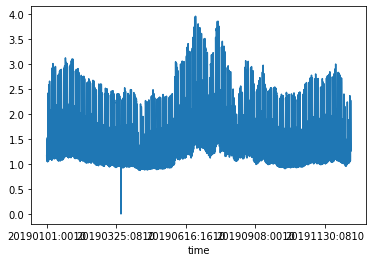

In [31]:
DF_Production['C_Residential'].plot()


<AxesSubplot:xlabel='time'>

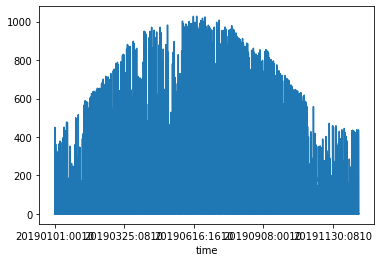

In [32]:
DF_Production["G(i)_East"].plot()

Optimization model

In [40]:
m = pyo.ConcreteModel()

#sets definition

#m.U = pyo.Set(initialize = ['C_Residential','C_Industrial', 'C_Commercial','P_Residential','P_Industrial', 'P_Commercial']) #utenti nel caso mi servisse var binaria se inserisco ci vuole within nei due set prod e cons
m.U_C = pyo.Set(initialize = ['C_Residential','C_Industrial', 'C_Commercial']) #chi consuma 
m.U_P = pyo.Set(initialize = ['P_Residential','P_Industrial', 'P_Commercial']) #chi produce
#m.U_CP = pyo.Set(within = m.U, initialize = ['Prosumer']) #chi consuma e produce



T = 8760 
m.T = pyo.RangeSet(0,T) #intervallo di tempo (1 anno)
CoefRes = 1
CoefInd = 1
CoefCom = 1
Area_Res_Max = 6360957.13 #m2 from QGIS
Area_Ind_Max = 78341.55 #m2 from QGIS
Area_Com_Max = 210725.647 #m2 from QGIS


#variables definition
#residential
m.RC = pyo.Var(domain=pyo.NonNegativeReals) #numero di m2 residential consumer
#m.RCP = pyo.Vardomain=pyo.NonNegativeReals) #numero di m2residential prosumer
m.RP = pyo.Var(domain=pyo.NonNegativeReals) #numero di m2 residential producer
#industrial
m.IC = pyo.Var(domain=pyo.NonNegativeReals) #numero di m2 industrial consumer
#m.ICP = pyo.Vardomain=pyo.NonNegativeReals) #numero di m2 industrial prosumer
m.IP = pyo.Var(domain=pyo.NonNegativeReals) #numero di m2 industrial producer
#commercial
m.CC = pyo.Var(domain=pyo.NonNegativeReals) #numero di m2 commercial consumer
#m.CCP = pyo.Vardomain=pyo.NonNegativeReals) #numero di m2 commercial prosumer
m.CP = pyo.Var(domain=pyo.NonNegativeReals) #numero di m2 commercial producer

#Dictionary for coefficients of roof
Roof_type = {'P_Residential': CoefRes , 'P_Industrial': CoefInd , 'P_Commercial': CoefCom }
Area_Max ={'Area_Res_Max' : 6360957.13, 'Area_Ind_Max' : 78341.55, 'Area_Com_Max' : 210725.647} #m2 from QGIS
yearlist = DF_Production.index

def obj_fun(m):
    TotProdRes = sum(m.RP*DF_Production.loc[t, 'Tot_Production [W/m2]']*Roof_type['P_Residential'] for t in yearlist)
    TotProdInd = sum(m.IP*DF_Production.loc[t, 'Tot_Production [W/m2]']*Roof_type['P_Industrial'] for t in yearlist)
    TotProdCom = sum(m.CP*DF_Production.loc[t, 'Tot_Production [W/m2]']*Roof_type['P_Commercial'] for t in yearlist)
    TotConsRes = sum(m.RC*DF_Production.loc[t, 'C_Residential'] for t in m.T)
    TotConsInd = sum(m.IC*DF_Production.loc[t, 'C_Industrial'] for t in m.T)
    TotConsCom = sum(m.CC*DF_Production.loc[t, 'C_Commercial'] for t in m.T)
    return abs(sum(TotProdRes + TotProdInd + TotProdCom) - sum(TotConsRes + TotConsInd + TotConsCom))

m.obj=pyo.Objective(rule=obj_fun,sense=pyo.minimize)

def Area_Residential_rule(m):
    return m.RP < Area_Max['Area_Res_Max']
m.Area_Residential_rule = pyo.Constraint(m.RP, rule = Area_Residential_rule)

def Area_Industrial_rule(m):
    return m.IP < Area_Max['Area_Ind_Max']
m.Area_Industrial_rule = pyo.Constraint(m.IP, rule = Area_Industrial_rule) 

def Area_Commercial_rule(m):
    return m.CP < Area_Max['Area_Com_Max']
m.Area_Commercial_rule = pyo.Constraint(m.CP, rule = Area_Commercial_rule)



ERROR: Rule failed when generating expression for Objective obj with index
    None: KeyError: 0
ERROR: Constructing component 'obj' from data=None failed: KeyError: 0


KeyError: 0